In [1]:
import os, pickle, warnings
from tqdm import tqdm
from pprint import pprint

import pandas as pd
import numpy as np

# modeling/experimentation
import mlflow
from scipy import interpolate
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# to load parameters of the experiments
from kedro.config import ConfigLoader

# utils
from joblib import Parallel, delayed
from pandas import IndexSlice as idx
from IPython.display import display

# viz
import seaborn as sns
import matplotlib.pyplot as plt

# experiments
from experiments.configs.evaluation import eval_sets
from experiments.noaa.deterministic import NOAADeterministicExperiment
from spatial_interpolation.visualization import map_viz
# print("Available experiment configs:",NOAADeterministicExperiment.config.config.keys())

# local utils and other imports
from spatial_interpolation.interpolators import ScipyInterpolator
from spatial_interpolation import data, utils
from spatial_interpolation.utils.experiments import conf 
from spatial_interpolation.data.load_data import get_ml_workspace
from spatial_interpolation.utils import tqdm_joblib
from spatial_interpolation.visualization import plot_interpolation, map_viz


# notebook configuration
import dotenv
warnings.simplefilter(action='ignore', category=FutureWarning)
dotenv.load_dotenv()

True

In [2]:
# load data
experiment = NOAADeterministicExperiment("linear_set3", n_jobs=1)
config = experiment.get_config()
dataset = data.NDBCDataLoader(**config.data_loading).load()
df, gdf = dataset.buoys_data, dataset.buoys_geo
available_time = df.index.get_level_values("time").unique()
time_range = pd.date_range(available_time.min(), available_time.max(), freq="H")

locations_within_area = gdf.loc[gdf.within(eval_sets.ndbc[config.eval_set].area)].index.get_level_values("buoy_id").unique()
df = df.loc[df.index.get_level_values("buoy_id").isin(locations_within_area)]
gdf = gdf.loc[idx[:, locations_within_area],:]
dataset = data.NDBCData(df, gdf)

train, test = dataset.split_slice(test=eval_sets.ndbc[config.eval_set].eval)
train_df = train.join()
test_df = test.join()

time_steps = (
    time_range
    .to_series(name="time_step")
    .rename_axis("time")
    .rank(ascending=True)
)

target = config.target
train_by_times = (
    train_df
    .reset_index()
    .rename(columns={"buoy_id": "location_id"})
    .set_index(["time", "location_id"])
    .sort_index()
    .dropna(subset=[target])
    .join(time_steps)
)
test_by_times = (
    test_df
    .reset_index()
    .rename(columns={"buoy_id": "location_id"})
    .set_index(["time", "location_id"])
    .sort_index()
    .dropna(subset=[target])
    .join(time_steps)
)


Split test obtained with dataset(s)=['buoys_data'] and shape(s)=[(122017, 14)]


In [5]:
time = pd.Timestamp(
    "2020-05-10 05:00"
 )

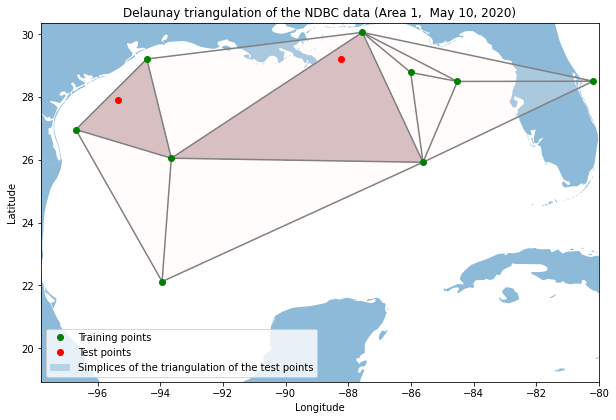

In [13]:
from scipy.spatial import Delaunay

dims = ["longitude","latitude"]
points = train_by_times.loc[time,dims].values
tri = Delaunay(points, incremental=True)
# plot the triangulation
fig,ax = plt.subplots(1,1,figsize=(10,10))
df_countries = data.load_world_borders()
df_countries.plot(ax=ax,alpha=0.5)
xmin, ymin, xmax, ymax = eval_sets.ndbc[config.eval_set].area.bounds
ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax)
ax.plot(points[:,0], points[:,1], 'o', color="green",label="Training points")
ax.set(xlabel="Longitude",ylabel="Latitude",title=f"Delaunay triangulation of the NDBC data (Area {config.eval_set[-1]}, {time: %b %d, %Y})")
ax.triplot(points[:,0], points[:,1], tri.simplices.copy(), color="grey")
test_points = test_by_times.loc[time,dims].values
ax.plot(test_points[:,0], test_points[:,1], 'o', color="red", label="Test points")
ind_tri = tri.find_simplex(test_points)
tri_mask = np.zeros(len(tri.simplices))
tri_mask[ind_tri] = 1
ax.tripcolor(
    points[:,0], points[:,1], tri.simplices.copy(), tri_mask, cmap="Reds", alpha=0.25, 
    label="Simplices of the triangulation of the test points")
closest_points = points[tri.simplices[ind_tri]][0]
ax.legend()

No handles with labels found to put in legend.


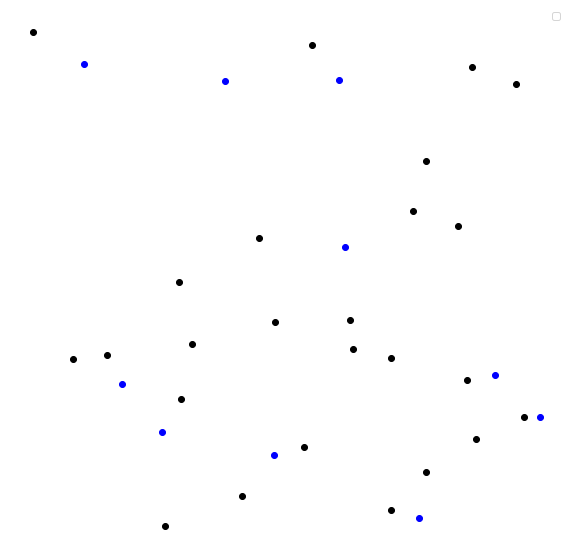

In [217]:
rand_points_X = np.random.uniform(xmin, xmax, size=(25,))
rand_points_Y = np.random.uniform(ymin, ymax, size=(25,))
rand_points = np.vstack([rand_points_X, rand_points_Y]).T
rand_points_new_X = np.random.uniform(xmin, xmax, size=(10,))
rand_points_new_Y = np.random.uniform(ymin, ymax, size=(10,))
rand_points_new = np.vstack([rand_points_new_X, rand_points_new_Y]).T
tri = Delaunay(rand_points, incremental=True)
ind_tri = tri.find_simplex(rand_points_new)
# plot the triangulation
fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.plot(rand_points[:,0], rand_points[:,1], 'o', color="black") # training points
ax.plot(rand_points_new[:,0], rand_points_new[:,1], 'o', color="blue") # test points 
# ax.triplot(rand_points[:,0], rand_points[:,1], tri.simplices.copy(), color="black")
tri_mask = np.zeros(len(tri.simplices))
tri_mask[ind_tri] = 1
# ax.tripcolor(
#     rand_points[:,0], rand_points[:,1], tri.simplices.copy(), tri_mask, 
#     cmap="Reds", alpha=0.25
# ) 
closest_points = rand_points[tri.simplices[ind_tri]].reshape(-1,2)
ax.legend()
# ax.plot(closest_points[:,0], closest_points[:,1], 'o', color="red")
ax.axis('off');

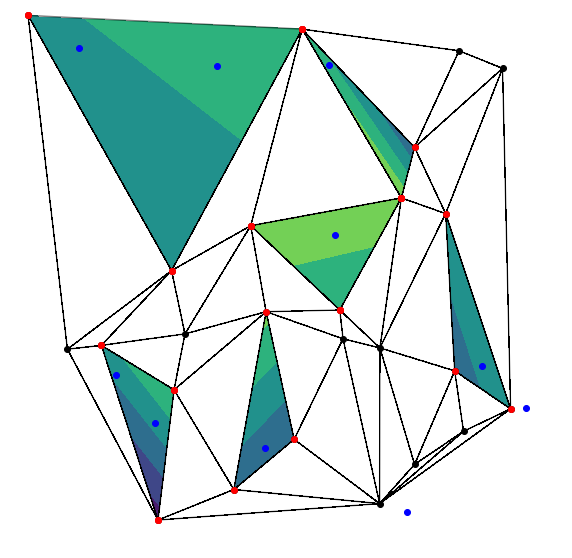

In [223]:
import matplotlib as mpl
# assign random values to each point
rand_values = np.random.uniform(0, 1, size=(len(rand_points),))
# interpolate
f = interpolate.LinearNDInterpolator(rand_points, rand_values)
# interpolate a grid
grid_x, grid_y = np.mgrid[xmin:xmax:500j, ymin:ymax:500j]
z = f(grid_x.ravel(), grid_y.ravel())
grid_z = z.reshape(grid_x.shape)
# plot the interpolation
fig,ax = plt.subplots(1,1,figsize=(10,10))
tri_mask = np.ones(len(tri.simplices)).astype(bool)
tri_mask[ind_tri] = 0
CS = ax.contourf(grid_x, grid_y, grid_z, cmap="viridis")
ax.scatter(rand_points_new[:,0], rand_points_new[:,1], marker='o', color="blue") # test points
ax.triplot(rand_points[:,0], rand_points[:,1], tri.simplices.copy(), color="black", alpha=0.5)
ax.tripcolor(
    rand_points[:,0], rand_points[:,1], tri.simplices[tri_mask], np.ones(len(tri.simplices[tri_mask])), 
    cmap=mpl.colors.ListedColormap("white"), color="black",
)
ax.scatter(rand_points[:,0], rand_points[:,1],color="black", marker='o',zorder=10)
ax.scatter(closest_points[:,0], closest_points[:,1],color="red", marker='o',zorder=11)
ax.axis('off');

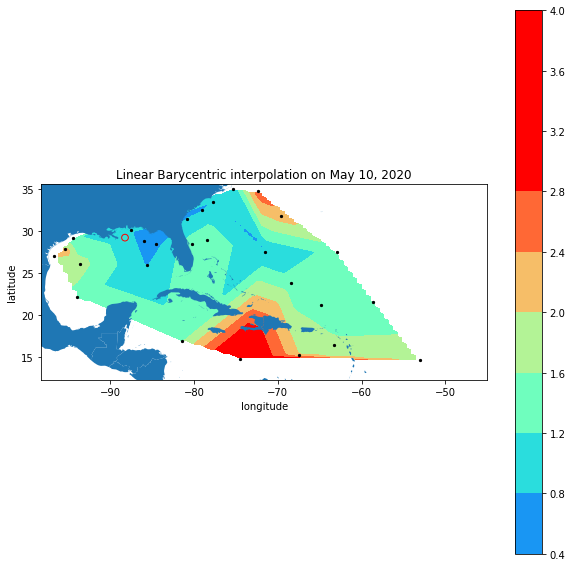

In [15]:
linear_interpolator = ScipyInterpolator(
    interpolate.LinearNDInterpolator,
    dimensions=[["longitude","latitude"]],
)
time = pd.Timestamp("2020-05-10 05:00")
linear_interpolator.fit(train_by_times.loc[time],y=target)
cm = plot_interpolation(
    train_by_times.loc[time,"longitude"],train_by_times.loc[time,"latitude"],
    test_by_times.loc[time,"longitude"],test_by_times.loc[time, "latitude"],
    test_by_times.loc[time][target],
    interpolator=linear_interpolator,
    bbox=eval_sets.ndbc[config.eval_set].area.bounds,
    radius=.4,
    title=f"Linear Barycentric interpolation on {time:%b %-d, %Y}",
    cmap="rainbow",
    zmin=0,zmax=3
)

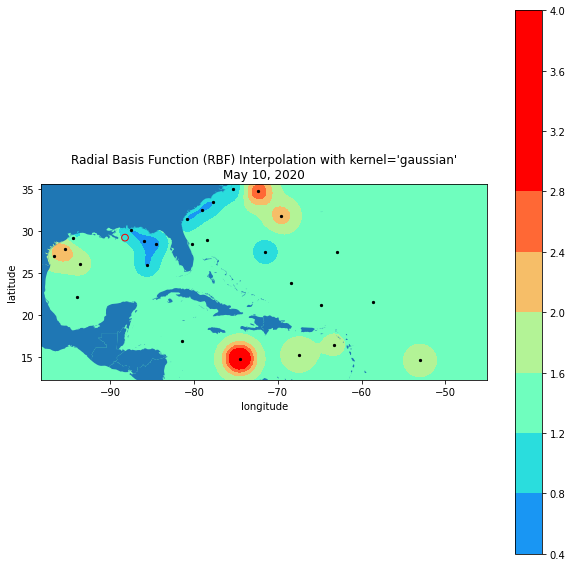

In [16]:
kernel = "gaussian"
rbf_interpolator = ScipyInterpolator(
    interpolate.RBFInterpolator,
    dimensions=[["longitude","latitude"]],
    kernel=kernel,
    epsilon=.6
)
rbf_interpolator.fit(train_by_times.loc[time],y=target)
plot_interpolation(
    train_by_times.loc[time,"longitude"],train_by_times.loc[time,"latitude"],
    test_by_times.loc[time,"longitude"],test_by_times.loc[time, "latitude"],
    test_by_times.loc[time][target],
    rbf_interpolator,
    bbox=eval_sets.ndbc[config.eval_set].area.bounds,
    radius=.4,
    cmap=cm.cmap,
    zmin=0,zmax=3,
    title=f"Radial Basis Function (RBF) Interpolation with {kernel=}\n{time:%b %-d, %Y}",
)

In [21]:
rbf_interpolator.predict(test_by_times.loc[time]), test_by_times.loc[time, target].values

(array([1.05091713]), array([1.05]))

### Temporal-Spatial Interpolation:

In [11]:
kernel = "gaussian"
rbf_interpolator = ScipyInterpolator(
    interpolate.RBFInterpolator,
    dimensions=[["longitude","latitude","time_step"]],
    kernel=kernel,
    epsilon=1/2
)
delta = pd.Timedelta(config.temp_interpolation.delta)
rbf_interpolator.fit(train_by_times.loc[(time-delta):time],y=target)
rbf_interpolator.predict(test_by_times.loc[time]), test_by_times.loc[time, target].values

array([0.96735728])

In [30]:
delta = pd.Timedelta("1D")
train_by_times.loc[(time-delta):time,["longitude","latitude", "time_step"]]

longitude  latitude  time_step
time                location_id                                
2020-05-09 05:00:00 41001          -72.317    34.724    81990.0
                    41004          -79.099    32.501    81990.0
                    41008          -80.866    31.400    81990.0
                    41009          -80.185    28.508    81990.0
                    41010          -78.485    28.878    81990.0
...                                    ...       ...        ...
2020-05-10 05:00:00 42055          -93.941    22.124    82014.0
                    42057          -81.422    16.908    82014.0
                    42058          -74.548    14.776    82014.0
                    42059          -67.483    15.252    82014.0
                    42060          -63.331    16.433    82014.0

[665 rows x 3 columns]

In [13]:
linear_interpolator = ScipyInterpolator(
    interpolate.LinearNDInterpolator,
    dimensions=[["longitude","latitude", "time_step"]],
)
delta = pd.Timedelta(config.temp_interpolation.delta)
time = train_by_times.index.get_level_values("time").min() #pd.Timestamp("2011-01-01 01:00")
time = pd.Timestamp("2019-04-12 02:00")
linear_interpolator.fit(train_by_times.loc[(time-delta):time],y=target)
linear_interpolator.predict(test_by_times.loc[time]), test_by_times.loc[time, target].values
# for time in tqdm(test_by_times.index.get_level_values("time").unique().to_series().sample(10)):
#     linear_interpolator.fit(train_by_times.loc[(time-delta):time],y=target)
#     linear_interpolator.predict(test_by_times.loc[time]), test_by_times.loc[time, target].values

(array([0.80442699]), array([0.7]))

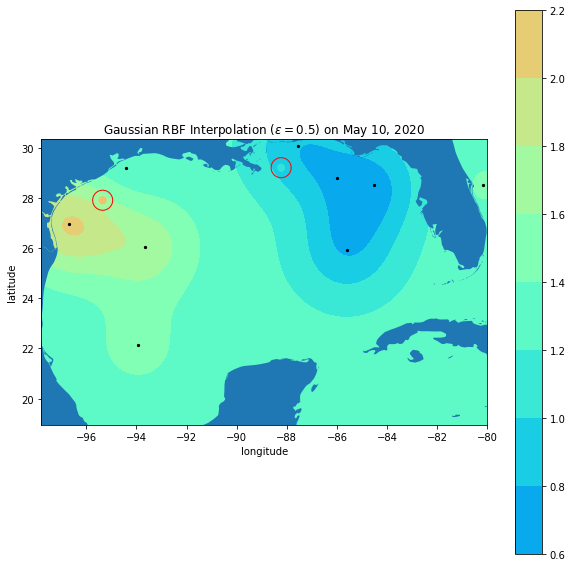

In [58]:
kernel = "gaussian"
time = pd.Timestamp(time)
epsilon=0.5
rbf_interpolator = ScipyInterpolator(
    interpolate.RBFInterpolator,
    dimensions=[["longitude","latitude"]],
    kernel=kernel,
    epsilon=epsilon
)
rbf_interpolator.fit(train_by_times.loc[time],y=target)
plot_interpolation(
    train_by_times.loc[time,rbf_interpolator.dim_cols[0]], train_by_times.loc[time,rbf_interpolator.dim_cols[1]],
    test_by_times.loc[time, rbf_interpolator.dim_cols[0]], test_by_times.loc[time, rbf_interpolator.dim_cols[1]],
    test_by_times.loc[time][target],
    rbf_interpolator,
    bbox=eval_sets.ndbc[config.eval_set].area.bounds,
    radius=.4,
    cmap="rainbow",
    zmin=0,zmax=3,
    title=f"{kernel.capitalize()} RBF Interpolation ($\{epsilon=}$) on {time:%b %-d, %Y}",
)

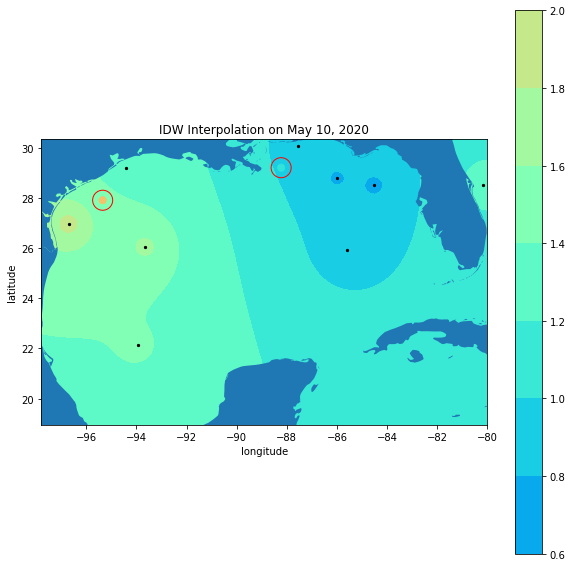

In [52]:
from spatial_interpolation.interpolators import IDWInterpolator
time = pd.Timestamp(time)
rbf_interpolator = ScipyInterpolator(
    IDWInterpolator,
    dimensions=[["longitude","latitude"]],
)
rbf_interpolator.fit(train_by_times.loc[time],y=target)
plot_interpolation(
    train_by_times.loc[time,rbf_interpolator.dim_cols[0]], train_by_times.loc[time,rbf_interpolator.dim_cols[1]],
    test_by_times.loc[time, rbf_interpolator.dim_cols[0]], test_by_times.loc[time, rbf_interpolator.dim_cols[1]],
    test_by_times.loc[time][target],
    rbf_interpolator,
    bbox=eval_sets.ndbc[config.eval_set].area.bounds,
    radius=.4,
    cmap="rainbow",
    zmin=0,zmax=3,
    title=f"IDW Interpolation on {time:%b %-d, %Y}",
)